<p style="font-family: Arials; font-size: 20px;text-align: center;; font-style: normal;line-height:1.3">In this challenge, we have simulated production control data and asked to predict whether the machine is in state 0 or state 1. The data contains a number of feature interactions that may be important in identifying the machine state. </p>

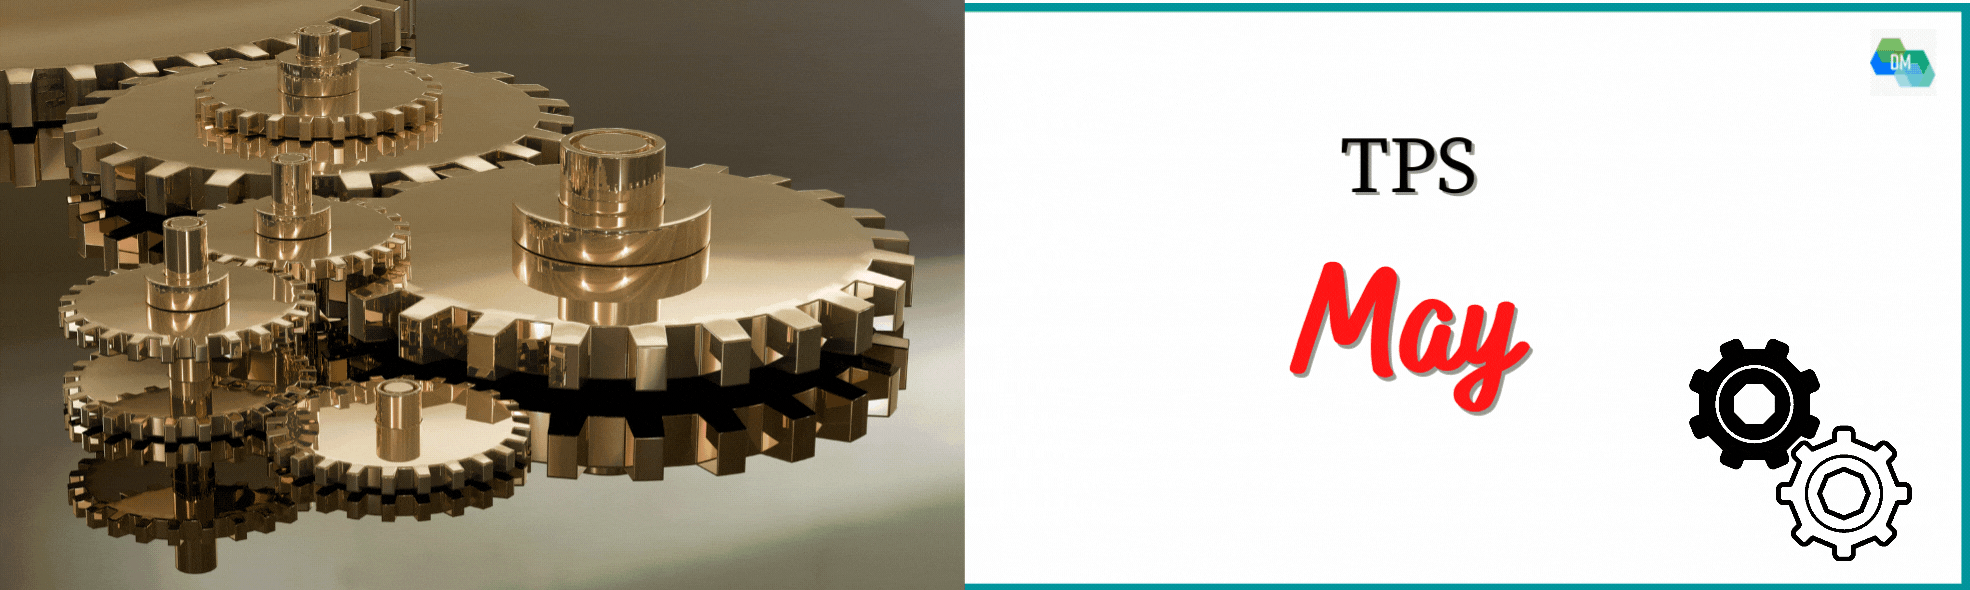

**Observations on this TPS dataset:**
- `target` column is the target variable which which represents the state of a manufacturing process
- `Train` dataset has `900,000` rows and `33` columns which contains`31` features, `1` target variable `target` and `1` column of `id`
- `Test` dataset has `700,000` rows and `32` columns which contains`31` features with`1` column of `id`
- No missing values in train and test dataset

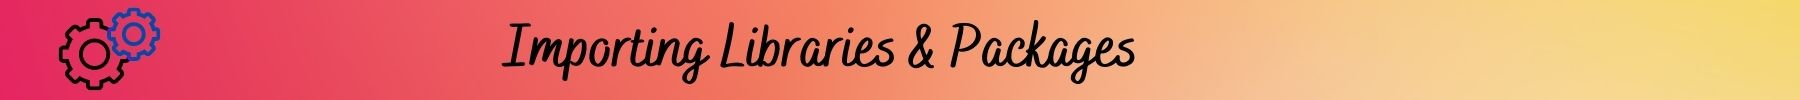

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

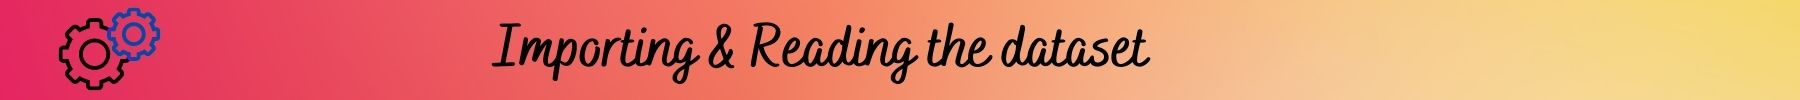

In [ ]:
df_train= pd.read_csv("../input/tabular-playground-series-may-2022/train.csv")
df_test= pd.read_csv("../input/tabular-playground-series-may-2022/test.csv")
df_subm= pd.read_csv("../input/tabular-playground-series-may-2022/sample_submission.csv")

In [ ]:
df_train.head()

In [ ]:
df_train.describe().T

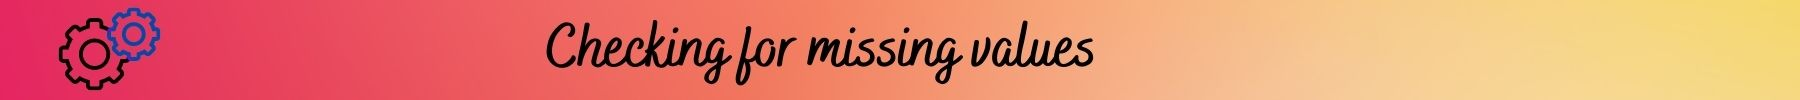

In [ ]:
df_train.isna().sum()

In [ ]:
df_test.isna().sum()

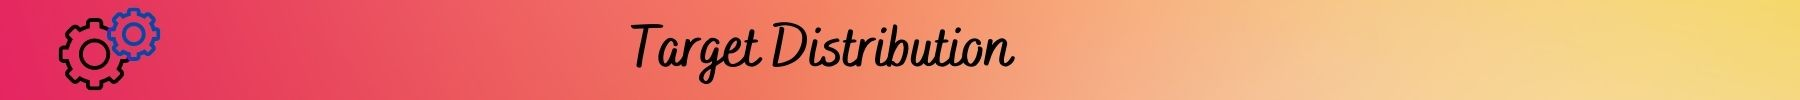

In [ ]:
target_class = pd.DataFrame({'count': df_train.target.value_counts(),
                             'percentage': df_train['target'].value_counts() / df_train.shape[0] * 100
})

In [ ]:
target_class

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Pie(values = target_class['count'],labels = target_class.index,hole = 0.6, 
                     hoverinfo ='label+percent'))
fig.update_traces(textfont_size = 12, hoverinfo ='label+percent',textinfo='label', 
                  showlegend = False,marker = dict(colors =["#201E1F","#FF4000"]),
                  title = dict(text = 'Target Distribution'))  
fig.show()

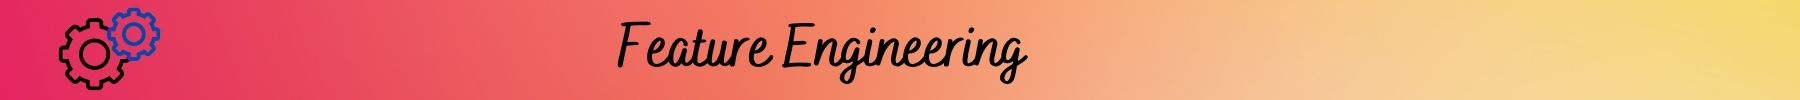

In [ ]:
#Reference: "https://www.kaggle.com/code/ambrosm/tpsmay22-keras-quickstart
def feature_engg(df):
    for i in range(10):
        df[f'ch{i}'] = df.f_27.str.get(i).apply(ord) - ord('A')
        df["unique_characters"] = df.f_27.apply(lambda s: len(set(s)))
    return df

In [ ]:
for df in [df_train, df_test]:
    df = feature_engg(df)

In [ ]:
from sklearn.preprocessing import StandardScaler
st = StandardScaler()
features = [feature for feature in df_train.columns if feature not in ['id', 'f_27', 'target']]
df_train[features] = st.fit_transform(df_train[features])
df_test[features] = st.transform(df_test[features])

In [ ]:
df_train.drop(columns = ['id','f_27'], inplace = True)
df_test.drop(columns = ['id','f_27'], inplace = True)

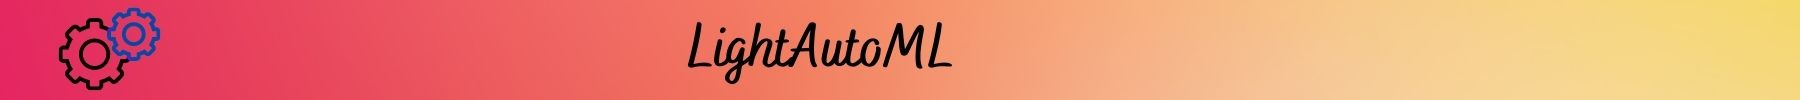

pip install lightautoml

In [ ]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco

In [ ]:
task = Task('binary')
roles = {'target': 'target'}
THREADS = 12
FOLDS = 10
RANDOM = 42
SIZE = 0.2
TIMEOUT = 28800
TARGET = 'target'

In [ ]:
automl = TabularAutoML(task = task, timeout = TIMEOUT, cpu_limit = THREADS,
                       reader_params = {'n_jobs': THREADS, 'cv': FOLDS, 'random_state': RANDOM})
pred = automl.fit_predict(df_train, roles = roles, verbose=3)

In [ ]:
predict_data = pred.data[:, 0]

In [ ]:
predict_test = automl.predict(df_test)

In [ ]:
df_test['target'] = predict_test.data[:, 0]

In [ ]:
df_subm['target'] = df_test['target']
df_subm

In [ ]:
df_subm.to_csv('submission_lightautoml.csv', index=False)

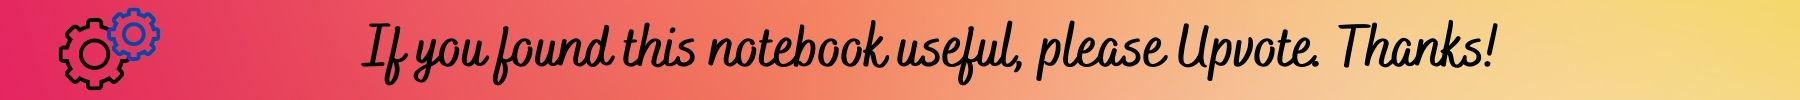